In [1]:
# 1 Carga y preprocesamiento
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Ruta local
file = r"C:\Users\Oscar Ferreira\OneDrive - AUTO LINEAS AMERICA SA DE CV\Escritorio\MCD\4 - APRENDIZAJE AUT\insurance.csv"
df = pd.read_csv(file)

# Features candidatas y target
feat_raw = ['age','bmi','children','sex','smoker','region']
target = 'charges'

X_raw = df[feat_raw].copy()
y = df[target].copy()

# One-hot para categóricas con drop de la categoría base (evita multicolinealidad perfecta)
X = pd.get_dummies(X_raw, columns=['sex','smoker','region'], drop_first=True)

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train.shape, X_test.shape, X.columns.tolist()



((1003, 8),
 (335, 8),
 ['age',
  'bmi',
  'children',
  'sex_male',
  'smoker_yes',
  'region_northwest',
  'region_southeast',
  'region_southwest'])

In [2]:
# 2) Método de filtro con SelectKBest

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

k = min(8, X_train.shape[1])  # puedes ajustar k

# 2.1 F-regression (lineal)
skb_f = SelectKBest(score_func=f_regression, k=k).fit(X_train, y_train)
scores_f = pd.DataFrame({
    'feature': X.columns,
    'score_f': skb_f.scores_,
    'pvalue_f': skb_f.pvalues_
}).sort_values('score_f', ascending=False)

# 2.2 Mutual Information (no paramétrico)
skb_mi = SelectKBest(score_func=mutual_info_regression, k=k).fit(X_train, y_train)
scores_mi = pd.DataFrame({
    'feature': X.columns,
    'score_mi': skb_mi.scores_
}).sort_values('score_mi', ascending=False)

# Merge rankings
rank = scores_f.merge(scores_mi, on='feature', how='outer')
rank['rank_f']  = rank['score_f'].rank(ascending=False, method='min')
rank['rank_mi'] = rank['score_mi'].rank(ascending=False, method='min')
rank = rank.sort_values(['rank_f','rank_mi'])
rank.reset_index(drop=True)


,feature,score_f,pvalue_f,score_mi,rank_f,rank_mi
0,smoker_yes,1575.534236,1.004438e-207,0.359481,1.0,2.0
1,age,94.309961,2.283456e-21,1.405343,2.0,1.0
2,bmi,39.917880,3.979241e-10,0.090193,3.0,5.0
3,children,6.418912,1.144277e-02,0.132493,4.0,4.0
4,region_southeast,2.816118,9.363400e-02,0.030285,5.0,6.0
5,sex_male,1.884876,1.700884e-01,0.139294,6.0,3.0
6,region_northwest,0.899905,3.430361e-01,0.016512,7.0,8.0
7,region_southwest,0.864407,3.527324e-01,0.021545,8.0,7.0


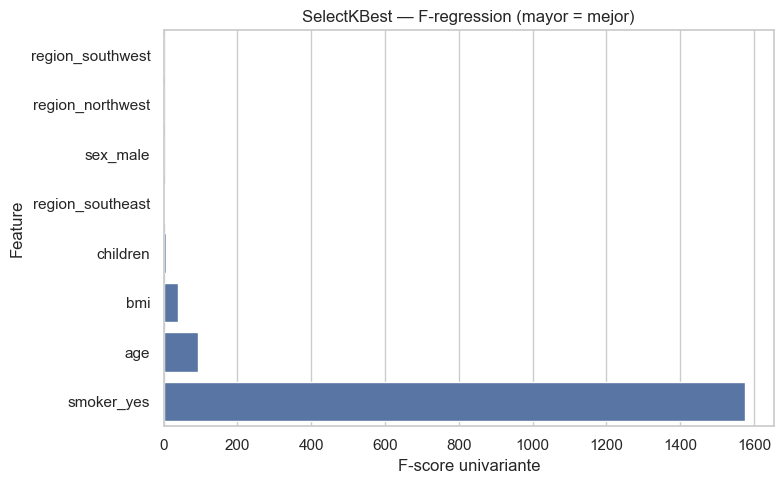

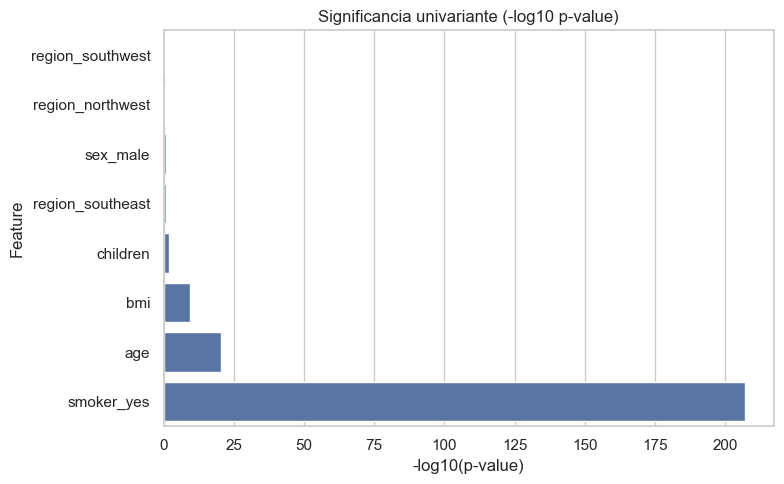

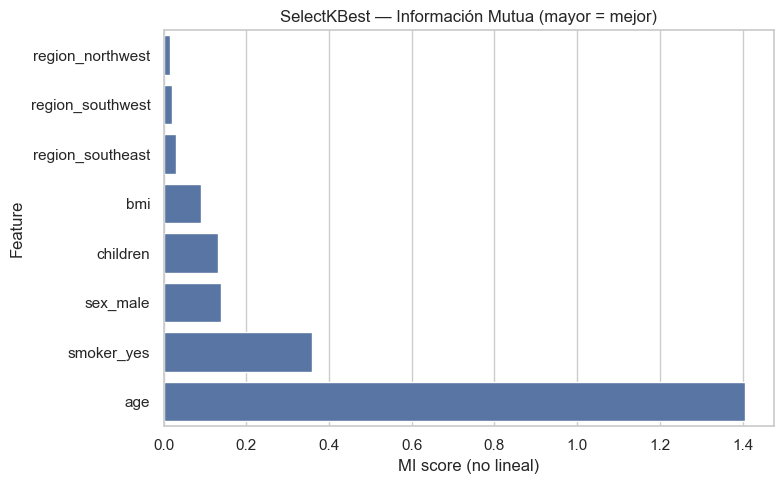

In [3]:
# 2) Método de filtro con SelectKBest (Visual)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- F-regression ---
plot_f = scores_f.sort_values('score_f', ascending=True)
plt.figure(figsize=(8,5))
sns.barplot(x='score_f', y='feature', data=plot_f, orient='h')
plt.title('SelectKBest — F-regression (mayor = mejor)')
plt.xlabel('F-score univariante')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# p-values en -log10 (opcional)
tmp = scores_f.copy()
tmp['neglog10_p'] = -np.log10(tmp['pvalue_f'])
tmp = tmp.sort_values('neglog10_p', ascending=True)
plt.figure(figsize=(8,5))
sns.barplot(x='neglog10_p', y='feature', data=tmp, orient='h')
plt.title('Significancia univariante (-log10 p-value)')
plt.xlabel('-log10(p-value)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- Mutual Information ---
plot_mi = scores_mi.sort_values('score_mi', ascending=True)
plt.figure(figsize=(8,5))
sns.barplot(x='score_mi', y='feature', data=plot_mi, orient='h')
plt.title('SelectKBest — Información Mutua (mayor = mejor)')
plt.xlabel('MI score (no lineal)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [4]:
# Modelos de selección de características, cuidando supuestos
# 3.1 LassoCV (lineal, con regularización L1 → “apaga” coeficientes)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV

num_cols = ['age','bmi','children']  # del set original
# El resto ya son dummies (0/1), que no escalaremos

# ColumnTransformer: escala solo numéricas
scaler = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='passthrough'
)

lasso = Pipeline([
    ('prep', scaler),
    ('model', LassoCV(cv=5, random_state=42))
])

lasso.fit(X_train, y_train)

coef = pd.Series(lasso.named_steps['model'].coef_, index=X.columns)
coef.sort_values(key=np.abs, ascending=False).to_frame('lasso_coef')


,lasso_coef
smoker_yes,23159.481797
age,3576.741644
bmi,1900.452375
children,455.714146
region_southwest,-69.604214
sex_male,0.000000
region_northwest,0.000000
region_southeast,-0.000000


In [5]:
# Modelos de selección de características, cuidando supuestos
# 3.2 RFE con LinearRegression (wrapper)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lin = Pipeline([
    ('prep', scaler),
    ('model', LinearRegression())
])

# Selecciona p.ej. 5 mejores
rfe = RFE(estimator=lin.named_steps['model'], n_features_to_select=5)
# Entrenamos en datos ya escalados para numéricas:
X_train_scaled = scaler.fit_transform(X_train)
rfe.fit(X_train_scaled, y_train)

rfe_selected = pd.Series(rfe.support_, index=X.columns, name='rfe_keep')
rfe_rank = pd.Series(rfe.ranking_, index=X.columns, name='rfe_rank').sort_values()
pd.concat([rfe_selected, rfe_rank], axis=1).sort_values('rfe_rank')


,rfe_keep,rfe_rank
age,True,1
bmi,True,1
region_southeast,True,1
smoker_yes,True,1
region_southwest,True,1
children,False,2
region_northwest,False,3
sex_male,False,4


In [6]:
# Modelos de selección de características, cuidando supuestos
# 3.3 RandomForestRegressor + Permutation Importance (no lineal)

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

rf = RandomForestRegressor(
    n_estimators=800, random_state=42, n_jobs=-1
).fit(X_train, y_train)

r2_base = r2_score(y_test, rf.predict(X_test))

perm = permutation_importance(
    rf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1
)
perm_imp = pd.DataFrame({
    'feature': X.columns,
    'perm_importance_mean': perm.importances_mean,
    'perm_importance_std': perm.importances_std
}).sort_values('perm_importance_mean', ascending=False)

r2_base, perm_imp.head(10)




(0.8503809680319809,
             feature  perm_importance_mean  perm_importance_std
 4        smoker_yes              1.455376             0.133906
 1               bmi              0.263024             0.037584
 0               age              0.194114             0.020133
 2          children              0.023238             0.005970
 7  region_southwest              0.003473             0.002066
 6  region_southeast              0.002305             0.001100
 5  region_northwest              0.000642             0.001924
 3          sex_male             -0.001355             0.002750)

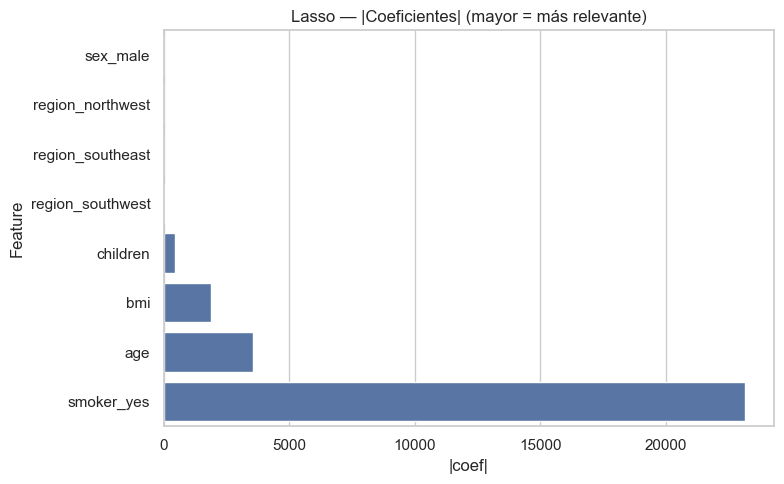

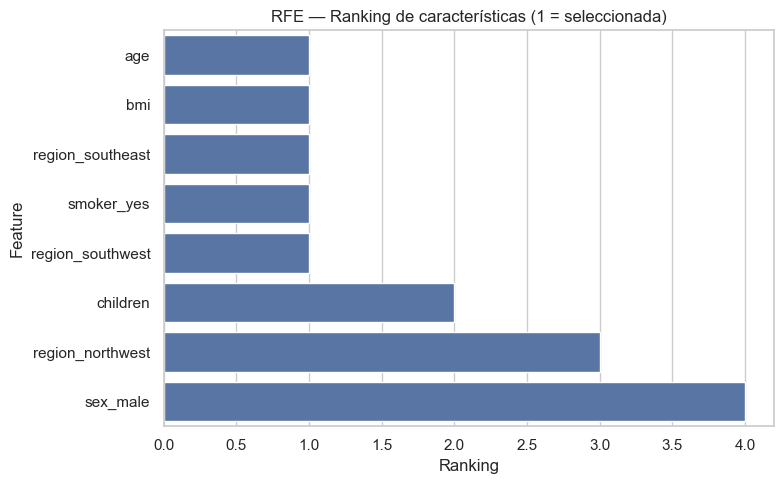

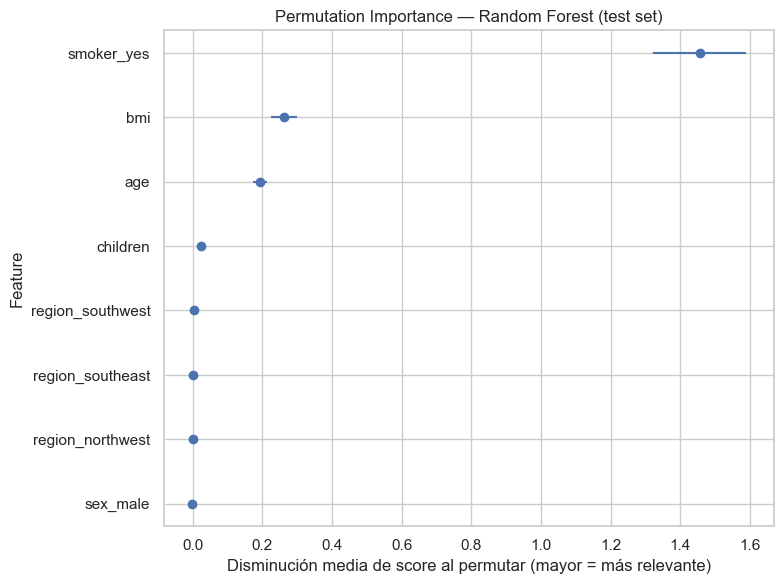

In [7]:
## # Modelos de selección de características, cuidando supuestos (visual)
# --- Lasso: magnitud de coeficientes ---
coef_abs = coef.abs().sort_values(ascending=True)
plt.figure(figsize=(8,5))
sns.barplot(x=coef_abs.values, y=coef_abs.index, orient='h')
plt.title('Lasso — |Coeficientes| (mayor = más relevante)')
plt.xlabel('|coef|')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- RFE: ranking (1 = se queda) ---
rfe_df = pd.concat([rfe_selected, rfe_rank], axis=1).sort_values('rfe_rank')
plt.figure(figsize=(8,5))
sns.barplot(x='rfe_rank', y=rfe_df.index, data=rfe_df, orient='h')
plt.title('RFE — Ranking de características (1 = seleccionada)')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- Permutation Importance (RF): mean ± std ---
top_pi = perm_imp.sort_values('perm_importance_mean', ascending=True)
plt.figure(figsize=(8,6))
plt.errorbar(
    top_pi['perm_importance_mean'], top_pi['feature'],
    xerr=top_pi['perm_importance_std'], fmt='o'
)
plt.title('Permutation Importance — Random Forest (test set)')
plt.xlabel('Disminución media de score al permutar (mayor = más relevante)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [8]:
# 4 Métricas/criterios desde la literatura (para seleccionar y comparar)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import pandas as pd
import math

# columnas numéricas potenciales (del set original)
base_num = ['age','bmi','children']

def make_ct_for(feats):
    """ColumnTransformer que solo escala las numéricas que EXISTEN en feats."""
    num_present = [c for c in base_num if c in feats]
    transformers = []
    if len(num_present) > 0:
        transformers.append(('num', StandardScaler(), num_present))
    # si no hay numéricas en el subset, solo pasamos todo tal cual
    return ColumnTransformer(transformers=transformers, remainder='passthrough')

def evaluate_subset(feats):
    X_sub = X[feats]

    ct = make_ct_for(feats)
    pipe = Pipeline([('prep', ct), ('model', LinearRegression())])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(pipe, X_sub, y, cv=cv, scoring='neg_mean_squared_error')).mean()
    r2   =        cross_val_score(pipe, X_sub, y, cv=cv, scoring='r2').mean()

    # AIC/BIC en train (comparativos)
    pipe.fit(X_train[feats], y_train)
    yhat = pipe.predict(X_train[feats])
    n = len(y_train)
    k_params = len(feats) + 1  # + intercepto
    rss = np.sum((y_train - yhat)**2)
    sigma2 = rss / n
    loglik = -0.5*n*(np.log(2*np.pi*sigma2) + 1)
    AIC = 2*k_params - 2*loglik
    BIC = k_params*np.log(n) - 2*loglik
    return rmse, r2, AIC, BIC

# --- reconstruir la curva usando el orden por |coef| de Lasso ---
ordered_by_lasso = coef.abs().sort_values(ascending=False).index.tolist()

rows = []
for k in range(1, len(ordered_by_lasso)+1):
    feats_k = ordered_by_lasso[:k]
    rmse, r2, AIC, BIC = evaluate_subset(feats_k)
    rows.append({'k': k, 'RMSE_CV': rmse, 'R2_CV': r2, 'AIC': AIC, 'BIC': BIC})

curve = pd.DataFrame(rows)
curve.head()



,k,RMSE_CV,R2_CV,AIC,BIC
0,1,7496.970593,0.607124,20751.354799,20761.176300
1,2,6412.488881,0.711455,20438.985208,20453.717460
2,3,6101.754126,0.738078,20343.714032,20363.357035
3,4,6076.206185,0.740356,20338.349795,20362.903549
4,5,6074.054947,0.740482,20339.220607,20368.685112


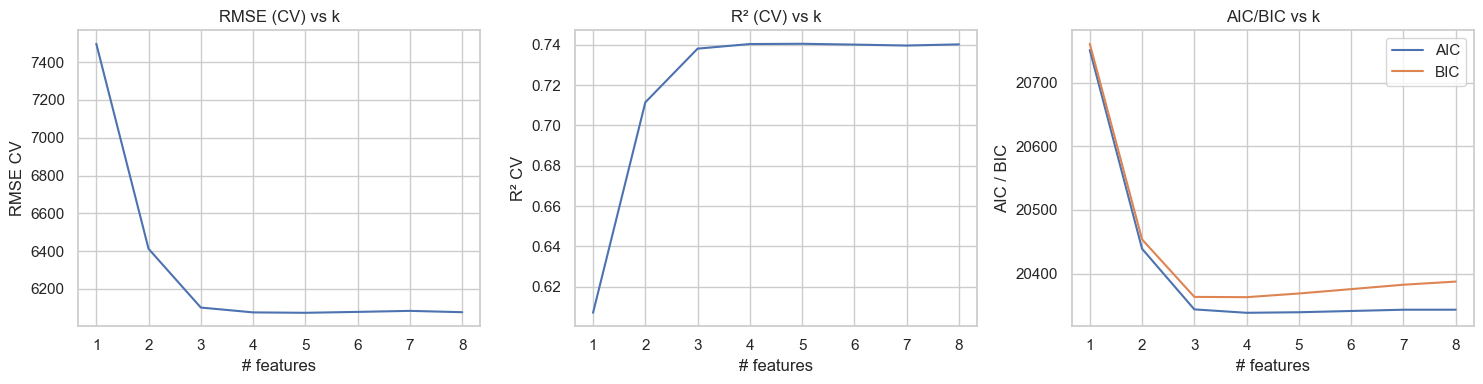

In [9]:
# 4 Métricas/criterios desde la literatura (para seleccionar y comparar) -- (Visual)

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15,4))
sns.lineplot(data=curve, x='k', y='RMSE_CV', ax=ax[0])
ax[0].set_title('RMSE (CV) vs k'); ax[0].set_xlabel('# features'); ax[0].set_ylabel('RMSE CV')

sns.lineplot(data=curve, x='k', y='R2_CV', ax=ax[1])
ax[1].set_title('R² (CV) vs k'); ax[1].set_xlabel('# features'); ax[1].set_ylabel('R² CV')

sns.lineplot(data=curve, x='k', y='AIC', ax=ax[2], label='AIC')
sns.lineplot(data=curve, x='k', y='BIC', ax=ax[2], label='BIC')
ax[2].set_title('AIC/BIC vs k'); ax[2].set_xlabel('# features'); ax[2].set_ylabel('AIC / BIC')
plt.tight_layout()
plt.show()


In [10]:
# 5 “Votación” de importancia y lista final de características

# Normaliza cada escala y suma puntajes (cuanto mayor, mejor)
rank_agg = pd.DataFrame(index=X.columns)

# De F-regression (scores_f) y MI (scores_mi)
rank_agg['z_f']  = (scores_f.set_index('feature')['score_f'] - scores_f['score_f'].mean())/scores_f['score_f'].std()
rank_agg['z_mi'] = (scores_mi.set_index('feature')['score_mi'] - scores_mi['score_mi'].mean())/scores_mi['score_mi'].std()

# Lasso abs coef
lasso_abs = coef.abs()
rank_agg['z_lasso'] = (lasso_abs - lasso_abs.mean())/lasso_abs.std()

# Permutation importance
pi = perm_imp.set_index('feature')['perm_importance_mean']
rank_agg['z_perm'] = (pi - pi.mean())/pi.std()

# (Opcional) bonificación si RFE mantiene la feature
if 'rfe_keep' in locals():
    keep = rfe_selected.replace({True:1, False:0})
    rank_agg['bonus_rfe'] = keep
else:
    rank_agg['bonus_rfe'] = 0

# Score total
rank_agg['score_total'] = rank_agg[['z_f','z_mi','z_lasso','z_perm']].sum(axis=1) + 0.25*rank_agg['bonus_rfe']
rank_agg.sort_values('score_total', ascending=False)


,z_f,z_mi,z_lasso,z_perm,bonus_rfe,score_total
smoker_yes,2.470525,0.180901,2.442891,2.422301,0,7.516618
age,-0.219809,2.404467,-0.008576,-0.096847,0,2.079235
bmi,-0.318601,-0.391621,-0.218423,0.040789,0,-0.887855
children,-0.379445,-0.301688,-0.399282,-0.438142,0,-1.518557
sex_male,-0.387680,-0.287229,-0.456331,-0.487260,0,-1.618500
region_southeast,-0.385988,-0.518990,-0.456331,-0.479951,0,-1.841260
region_southwest,-0.389533,-0.537570,-0.447617,-0.477618,0,-1.852339
region_northwest,-0.389469,-0.548270,-0.456331,-0.483272,0,-1.877342


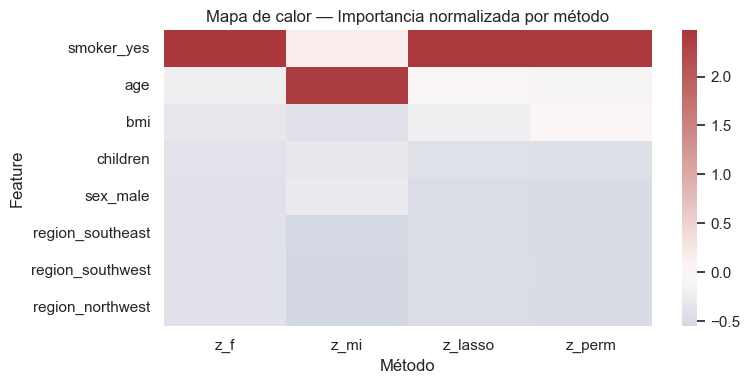

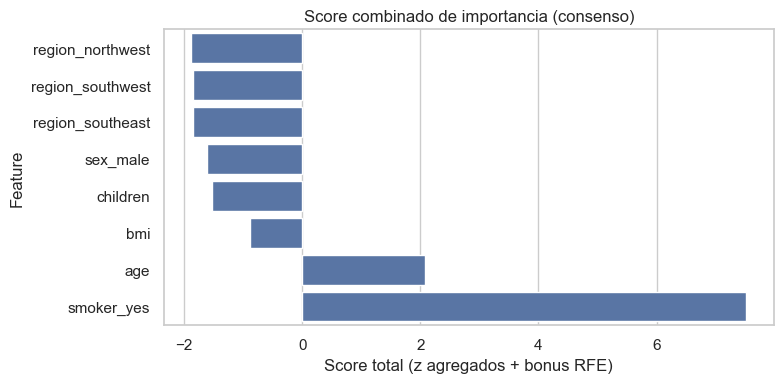

In [11]:
# 5 “Votación” de importancia y lista final de características (Visual)

# Heatmap de z-scores (z_f, z_mi, z_lasso, z_perm)
mat = rank_agg[['z_f','z_mi','z_lasso','z_perm']].copy()
mat = mat.loc[rank_agg['score_total'].sort_values(ascending=False).index]  # ordenar por score total

plt.figure(figsize=(8, max(4, 0.4*len(mat))))
sns.heatmap(mat, annot=False, cmap='vlag', center=0)
plt.title('Mapa de calor — Importancia normalizada por método')
plt.xlabel('Método'); plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Barras del score total
rank_plot = rank_agg.sort_values('score_total').copy()
plt.figure(figsize=(8, max(4, 0.4*len(rank_plot))))
sns.barplot(x='score_total', y=rank_plot.index, data=rank_plot, orient='h')
plt.title('Score combinado de importancia (consenso)')
plt.xlabel('Score total (z agregados + bonus RFE)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
